## 1. Introduction et data loading 
This first step consists of importing and examining the dataset, as well as preparing it for exploratory analysis.

#### A. Import library

In [17]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math
df_train = pd.read_csv("train.csv")
np.random.seed(123)
n = len(df_train)

yes = df_train[df_train.Loan_Status=="Y"]
no = df_train[df_train.Loan_Status=="N"]
n_yes = df_train[df_train.Loan_Status=="Y"].shape[0]
n_no = df_train[df_train.Loan_Status=="N"].shape[0]

age_yes = np.concatenate( [np.random.randint(32,58,int(n_yes*0.7)),np.random.randint(18,29,int((n_yes*0.3)+1))])
age_no = np.concatenate( [np.random.randint(32,58,int(n_no*0.2)),np.random.randint(61,85,int(n_no*0.3)),np.random.randint(18,29,int((n_no*0.5)+1))])


mask_yes = df_train.Loan_Status == "Y"
mask_no  = df_train.Loan_Status == "N"

df_train.loc[mask_yes, "age"] = age_yes
df_train.loc[mask_no,  "age"] = age_no


df = df_train.copy()


def drop_id(df):
    if not df["Loan_ID"].is_unique:
        print("Duplicates detected. Removing...")
        df = df.drop_duplicates(subset="Loan_ID")
    else:
        print("No duplicates on Loan_ID and we droped this column")
    df = df.drop("Loan_ID", axis=1)
    return df

df = drop_id(df)

No duplicates on Loan_ID and we droped this column


## Preprocessing

We can see that there are outliers in the numerical variables. To address this issue, we replace the missing values for the numerical variables with the median. For the categorical variables, we replace them with the most frequent category.

In [18]:
def replace_missing_value(df):
    for col in df.columns:
        if df[col].isna().sum() > 0:
            if df[col].dtype == 'object' or df[col].nunique() < 15 :
                if not df[col].mode().empty:
                    most_frequent = df[col].mode()[0]
                    df[col] = df[col].fillna(most_frequent)
                    df[col].astype('object')
            elif pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 15:
                med_val = df[col].median()
                if pd.notna(med_val):
                    df[col] = df[col].fillna(med_val)   



In [19]:
replace_missing_value(df)
df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
age                  float64
dtype: object

## Outliers

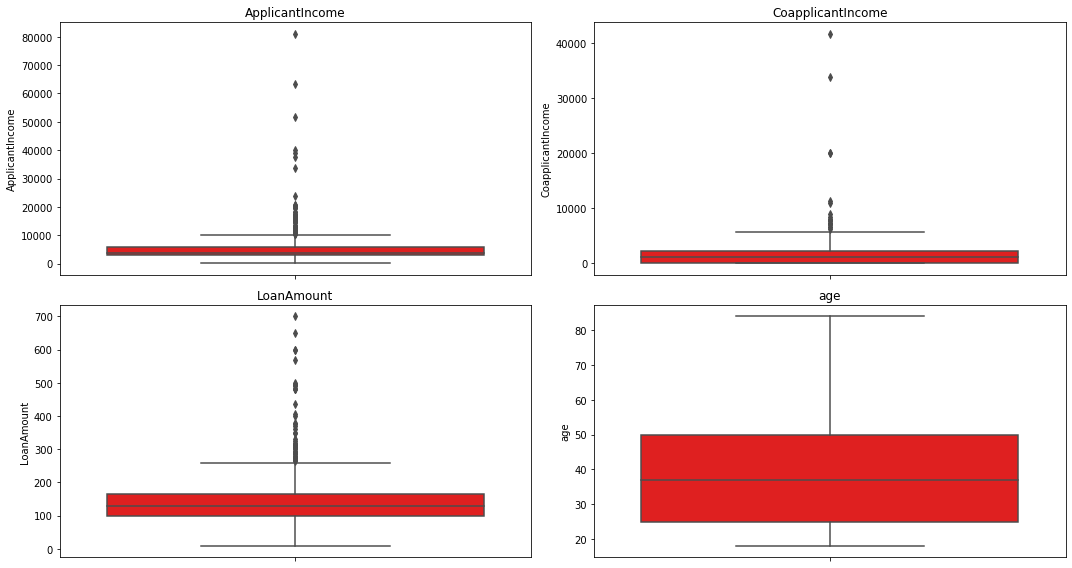

In [20]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(["Loan_Amount_Term", "Credit_History"])

plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col], color="red")
    plt.title(f'{col}')
plt.tight_layout()
plt.show()



In [21]:
#Z-score avec seuil = 3


z = df[num_cols].apply(lambda x: (x - x.mean()) / x.std(ddof=0))


outliers = df[(z.abs() > 3).any(axis=1)]

print("Outliers :")
print(outliers.shape)


Outliers :
(25, 13)


In [22]:

def plot_outliers_hist(df, list_col, threshold=3):
    for i in range(0, len(list_col), 4):
        batch = list_col[i : i + 4]
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        for ax, col in zip(axes, batch):
            data = df[col].dropna()
            zs = (data - data.mean()) / data.std(ddof=0)
            outlier_mask = zs.abs() > threshold

            ax.hist(data, bins='auto', alpha=0.6,
                    color='lightcoral', edgecolor='darkred', linewidth=0.5)
            ax.scatter(data[outlier_mask], [0]*outlier_mask.sum(),
                       color='red', marker='o', label='Outliers', zorder=5)
            ax.set_title(f"{col} — outliers (|z| > {threshold})")
            ax.set_xlabel(col)
            ax.set_ylabel("Fréquence")
            ax.legend(fontsize='small')

        # Supprimer axes vides si batch < 4
        for j in range(len(batch), 4):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()



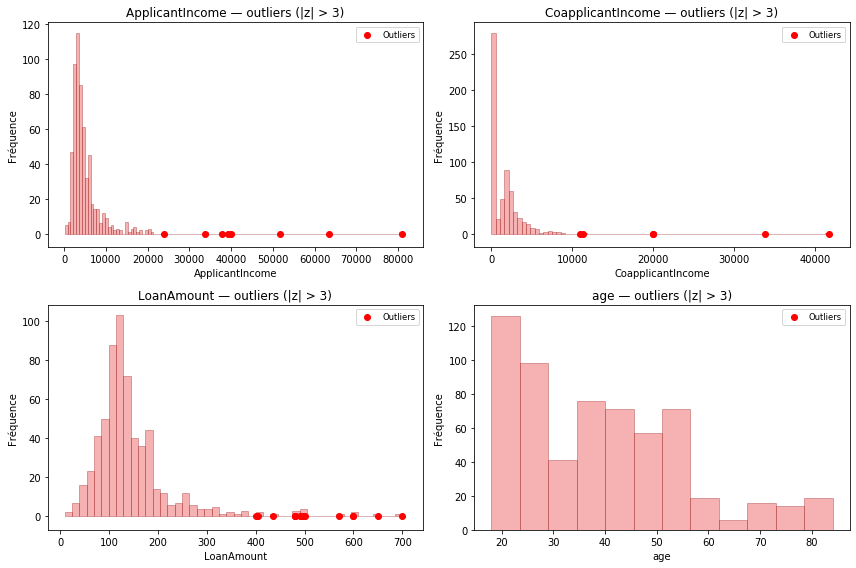

In [9]:
plot_outliers_hist(df, num_cols)

In [23]:
z_scores = stats.zscore(df[num_cols])
z_df = pd.DataFrame(z_scores, columns=num_cols, index=df.index)
threshold = 3
mask = (z_df.abs() <= threshold).all(axis=1)

df_sans_outliers = df[mask].copy()


In [24]:
df_sans_outliers.shape

(589, 13)

There are 589 observations remaining in our dataset.

We added two variables calculated from the existing ones: 
Total_income = ApplicantIncome + CoapplicantIncome  (which is the applicant's income plus the co-applicant's income)
MonthlyPayment = LoanAmount*1000 / Loan_Amount_Term  (monthly loan amount requested, which is the loan amount divided by the loan term)
DebtToIncomeRatio = MonthlyPayment / TotalIncome

In [25]:
df_sans_outliers["LoanAmountScale"] = df_sans_outliers["LoanAmount"]*1000
df_sans_outliers = df_sans_outliers.drop("LoanAmount", axis=1)
df_sans_outliers["TotalIncome"] = df_sans_outliers["ApplicantIncome"] + df_sans_outliers["CoapplicantIncome"]
df_sans_outliers["MonthlyPayment"] = df_sans_outliers["LoanAmountScale"] / df_sans_outliers["Loan_Amount_Term"]
df_sans_outliers["DebtToIncomeRatio"] = df_sans_outliers["MonthlyPayment"] / (df_sans_outliers["TotalIncome"])


In [31]:
df_sans_outliers["TotalIncomeCut"] = pd.cut(df_sans_outliers['TotalIncome'], bins=5)

In [30]:
df_sans_outliers.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,age,LoanAmountScale,TotalIncome,MonthlyPayment,DebtToIncomeRatio,IncomeCut
0,Male,No,0,Graduate,No,5849,0.0,360.0,1.0,Urban,Y,45.0,128000.0,5849.0,355.555556,0.060789,"(5287.0, 9132.0]"
1,Male,Yes,1,Graduate,No,4583,1508.0,360.0,1.0,Rural,N,48.0,128000.0,6091.0,355.555556,0.058374,"(5287.0, 9132.0]"
2,Male,Yes,0,Graduate,Yes,3000,0.0,360.0,1.0,Urban,Y,34.0,66000.0,3000.0,183.333333,0.061111,"(1422.775, 5287.0]"
3,Male,Yes,0,Not Graduate,No,2583,2358.0,360.0,1.0,Urban,Y,34.0,120000.0,4941.0,333.333333,0.067463,"(1422.775, 5287.0]"
4,Male,No,0,Graduate,No,6000,0.0,360.0,1.0,Urban,Y,38.0,141000.0,6000.0,391.666667,0.065278,"(5287.0, 9132.0]"
5,Male,Yes,2,Graduate,Yes,5417,4196.0,360.0,1.0,Urban,Y,49.0,267000.0,9613.0,741.666667,0.077152,"(9132.0, 12977.0]"
6,Male,Yes,0,Not Graduate,No,2333,1516.0,360.0,1.0,Urban,Y,51.0,95000.0,3849.0,263.888889,0.068560,"(1422.775, 5287.0]"
7,Male,Yes,3+,Graduate,No,3036,2504.0,360.0,0.0,Semiurban,N,36.0,158000.0,5540.0,438.888889,0.079222,"(5287.0, 9132.0]"
8,Male,Yes,2,Graduate,No,4006,1526.0,360.0,1.0,Urban,Y,42.0,168000.0,5532.0,466.666667,0.084358,"(5287.0, 9132.0]"
10,Male,Yes,2,Graduate,No,3200,700.0,360.0,1.0,Urban,Y,57.0,70000.0,3900.0,194.444444,0.049858,"(1422.775, 5287.0]"


c:\Users\hanal\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


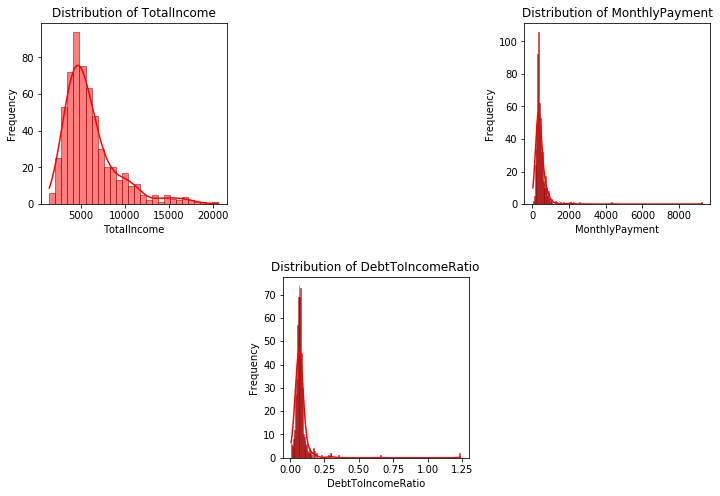

In [14]:
cols = ["TotalIncome", "MonthlyPayment", "DebtToIncomeRatio"]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 2])  
ax3 = fig.add_subplot(gs[1, 1]) 


sns.histplot(df_sans_outliers[cols[0]].dropna(), kde=True,
             color='red', edgecolor='darkred', linewidth=0.5, ax=ax1)
ax1.set_title(f'Distribution of {cols[0]}')
ax1.set_xlabel(cols[0])
ax1.set_ylabel("Frequency")


sns.histplot(df_sans_outliers[cols[1]].dropna(), kde=True,
             color='red', edgecolor='darkred', linewidth=0.5, ax=ax2)
ax2.set_title(f'Distribution of {cols[1]}')
ax2.set_xlabel(cols[1])
ax2.set_ylabel("Frequency")


sns.histplot(df_sans_outliers[cols[2]].dropna(), kde=True,
             color='red', edgecolor='darkred', linewidth=0.5, ax=ax3)
ax3.set_title(f'Distribution of {cols[2]}')
ax3.set_xlabel(cols[2])
ax3.set_ylabel("Frequency")

plt.tight_layout()
plt.show();